# Word Embedding 
---
Word2Vec을 구현해 보자.

# Word embedding이란? 

단어 임베딩(Word Embedding)이란 텍스트를 구성하는 하나의 단어를 수치화하는 방법의 일종이다.

텍스트에 나타난 단어를 수만개가 될수 있는데 이것을 one-hot encoding 방식으로 처리하는 것은 매우 비효율적이다. 단어를 one-hot vector로 나타내면 대부분 0 값이 된다. hidden layer에서 one-hot input vector와 연산이 대부분 0이 된다.

이런 비효율성을 개선하기 위한 것이 embeddings 이다. Embedding layer는 앞서 본 fully connected layer와 같은 형태이다. embedding layer의 weights를 embedding weights라고 한다.

matrix multiplication을 수행하는 대신에 weight matrix를 lookup table로 사용한다. words를 integers 로 변환하게 된다. "heart" 단어가 958로 encode 되었다면, 해당 hidden layer values는 그냥 embedding matrix에서 958번째 row 를 가져오면 된다. 이것을 embedding lookup 라고 하고 hidden units의 갯수가 embedding dimension이 된다.

embedding lookup table은 단순한 weight matrix이고 embedding layer는 hidden layer이다. lookup 은 matrix multiplication을 대체하는 것이다. embedding layer는 weight matrix(=embedding vector)를 학습하게 된다.

Word2Vec 은 embedding layer를 통해서 word를 벡터로 표현한다.

![IMG](../assets/embedding2.png?raw=1)

# Skip-Gram 방식

Word2Vec에는 Continous Bag Of Words (CBOW) 와 Skip-Gram의 두 가지 모델이 있다 . Skip-Gram 모델은 중심 단어가 주어진 문맥 단어를 예측하는 반면 CBOW 모델은 문맥 단어로 주어진 중심 단어를 예측한다. 

* Skip-gram : 소량의 훈련 데이터와 잘 작동하며, 희귀 한 단어 나 문구도 잘 표현한다.

* CBOW : 스킵 그램보다 훈련 속도가 빠르고, 빈도가 높은 단어에 대해 약간 더 나은 정확도를 보인다.

Skip-Gram 모델의 궁극적 인 목표는 문맥 단어를 예측하는 것이 아니라 단어의 지능적인 벡터 표현을 학습하는 것이다.

![IMG](../assets/word2vec_skip-gram.png)

Word2Vec에서 단어는 벡터로 표시되며 **관련 단어는 벡터 공간에서 서로 가깝게 배치**된다. 수학적으로 이것은 **관련 단어 사이의 거리(=Cisine 유사도)**가 관련 없는 단어보다 더 가깝게 배치된다는 것이다. 

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


# 훈련데이터 준비

* IMDB 데이터 사용 - Word Embedding은 단어 벡터의 크기를 임의로 조정하므로 사용되는 단어의 갯수에 크게 영향을 받지 않는다.

* 이 경우 사용되는 단어의 갯수를 1000으로 한다.

In [2]:
import numpy as np
from tensorflow.keras.datasets import imdb

In [3]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)

In [4]:
from tensorflow.keras.layers import Embedding

In [5]:
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]

print(x_train_all[0])


[22, 43, 530, 973, 65, 458, 66, 173, 36, 256, 25, 100, 43, 838, 112, 50, 670, 35, 480, 284, 150, 172, 112, 167, 336, 385, 39, 172, 546, 38, 447, 192, 50, 147, 22, 469, 22, 71, 87, 43, 530, 38, 76, 22, 515, 626, 62, 386, 316, 106, 480, 66, 33, 130, 38, 619, 25, 124, 51, 36, 135, 48, 25, 33, 22, 215, 28, 77, 52, 407, 82, 107, 117, 256, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 104, 88, 381, 297, 98, 32, 56, 26, 141, 194, 226, 22, 21, 134, 476, 26, 480, 144, 30, 51, 36, 28, 224, 92, 25, 104, 226, 65, 38, 88, 283, 113, 103, 32, 178, 32]


In [6]:
from sklearn.model_selection import train_test_split

x_train,x_val,y_train,y_val = train_test_split(x_train_all, y_train_all, test_size=0.2, random_state=123)

print(x_train.shape, x_val.shape)

(20000,) (5000,)


In [7]:
from tensorflow.keras.preprocessing import sequence

max_len = 100
x_train_seq = sequence.pad_sequences(x_train, maxlen=max_len)
x_val_seq = sequence.pad_sequences(x_val, maxlen=max_len)

print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


# 모형의 생성


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [9]:
model_ebd = Sequential()

model_ebd.add(Embedding(1000,32))
model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation='sigmoid'))

model_ebd.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 8)                 328       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


# 모델 컴파일 & 훈련 

In [10]:
model_ebd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history=model_ebd.fit(x_train_seq, y_train, epochs=10, batch_size=32, 
                      validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 6s 9ms/step - loss: 0.5235 - accuracy: 0.7649 - val_loss: 0.4562 - val_accuracy: 0.7988
Epoch 2/10
625/625 [==============================] - 6s 9ms/step - loss: 0.4124 - accuracy: 0.8234 - val_loss: 0.4215 - val_accuracy: 0.8112
Epoch 3/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3718 - accuracy: 0.8425 - val_loss: 0.4043 - val_accuracy: 0.8238
Epoch 4/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3463 - accuracy: 0.8554 - val_loss: 0.3981 - val_accuracy: 0.8292
Epoch 5/10
625/625 [==============================] - 6s 9ms/step - loss: 0.3209 - accuracy: 0.8682 - val_loss: 0.4109 - val_accuracy: 0.8214
Epoch 6/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2954 - accuracy: 0.8808 - val_loss: 0.4161 - val_accuracy: 0.8274
Epoch 7/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2786 - accuracy: 0.8884 - val_loss: 0.4324 - val_accuracy: 0.8272
Epoch 

# 모형 훈련 결과 시각화하기 

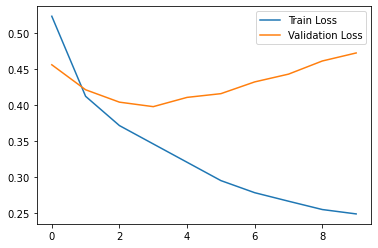

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

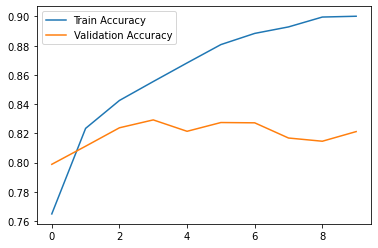

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# 모형의 평가

원-핫 인코딩 방식을 사용하지 않아 메모리 사용량이 절감된다. 또 rnn의 cell 갯수를 줄여도 더 높은 성능을 보였다. 

워드 임베딩 방식이 효율적이고 성능이 뛰어나기 때문에 텍스트 처리를 할 때는 워드 임베딩 층이 기본적으로 사용된다. 

In [13]:
loss, acc = model_ebd.evaluate(x_val_seq, y_val, verbose=0)
print(acc)

0.8212000131607056
